# Pix2Pix

本notebook演示了通过使用conditional GAN进行图像到图像的转换，正如在[Image-to-Image Translation with Conditional Adversarial Networks](https://arxiv.org/abs/1611.07004)这篇论文中所描述的那样。使用这种技术，我们可以将黑白照片着色，转换谷歌地图到谷歌地球，等等。在这里，我们将建筑立面转换为真实的建筑。

例如，我们将使用由位于布拉格的捷克技术大学的机器感知中心提供的CMP立面数据库。为了简短示例，我们将使用上述论文作者创建的这个数据集的一个预处理副本。

在一个V100 GPU上，每个epoch大约需要15秒。

下面是训练模型200个epoch后生成的输出。


![在这里插入图片描述](https://img-blog.csdnimg.cn/20201109233004198.png?x-oss-process=image/watermark,type_ZmFuZ3poZW5naGVpdGk,shadow_10,text_aHR0cHM6Ly9ibG9nLmNzZG4ubmV0L3FxXzQyMjMxNzk5,size_16,color_FFFFFF,t_70#pic_center)

![在这里插入图片描述](https://img-blog.csdnimg.cn/20201109233033735.png?x-oss-process=image/watermark,type_ZmFuZ3poZW5naGVpdGk,shadow_10,text_aHR0cHM6Ly9ibG9nLmNzZG4ubmV0L3FxXzQyMjMxNzk5,size_16,color_FFFFFF,t_70#pic_center)

## 导入Tensorflow及其他库

In [1]:
import tensorflow as tf

import os
import time

from matplotlib import pyplot as plt
from IPython import display

```bash
pip install -q -U tensorboard
```

WARNING: You are using pip version 20.2.2; however, version 20.2.3 is available.
You should consider upgrading via the '/tmpfs/src/tf_docs_env/bin/python -m pip install --upgrade pip' command.

## 加载数据集

您可以从这里[下载](https://people.eecs.berkeley.edu/~tinghuiz/projects/pix2pix/datasets/)此数据集和类似的数据集。正如在[论文](https://arxiv.org/abs/1611.07004)中提到的，我们对训练数据集应用随机抖动和镜像。

 - 在随机抖动中，图像被调整为286 x 286，然后随机裁剪为256 x 256
 - 在随机镜像中，图像被随机地水平翻转，即从左到右。

In [3]:
_URL = 'https://people.eecs.berkeley.edu/~tinghuiz/projects/pix2pix/datasets/facades.tar.gz'

path_to_zip = tf.keras.utils.get_file('facades.tar.gz',
                                      origin=_URL,
                                      extract=True)

PATH = os.path.join(os.path.dirname(path_to_zip), 'facades/')

30171136/30168306 [==============================] - 22s 1us/step


In [4]:
BUFFER_SIZE = 400
BATCH_SIZE = 1
IMG_WIDTH = 256
IMG_HEIGHT = 256

In [5]:
def load(image_file):
  image = tf.io.read_file(image_file)
  image = tf.image.decode_jpeg(image)

  w = tf.shape(image)[1]

  w = w // 2
  real_image = image[:, :w, :]
  input_image = image[:, w:, :]

  input_image = tf.cast(input_image, tf.float32)
  real_image = tf.cast(real_image, tf.float32)

  return input_image, real_image

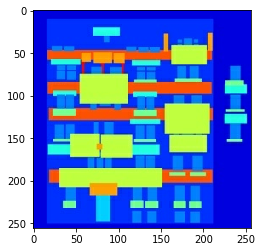

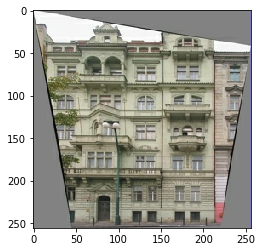

In [6]:
inp, re = load(PATH+'train/100.jpg')
# casting to int for matplotlib to show the image
plt.figure()
plt.imshow(inp/255.0)
plt.figure()
plt.imshow(re/255.0)

In [7]:
def resize(input_image, real_image, height, width):
  input_image = tf.image.resize(input_image, [height, width],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  real_image = tf.image.resize(real_image, [height, width],
                               method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  return input_image, real_image

In [8]:
def random_crop(input_image, real_image):
  stacked_image = tf.stack([input_image, real_image], axis=0)
  cropped_image = tf.image.random_crop(
      stacked_image, size=[2, IMG_HEIGHT, IMG_WIDTH, 3])

  return cropped_image[0], cropped_image[1]

In [9]:
# normalizing the images to [-1, 1]

def normalize(input_image, real_image):
  input_image = (input_image / 127.5) - 1
  real_image = (real_image / 127.5) - 1

  return input_image, real_image

In [10]:
@tf.function()
def random_jitter(input_image, real_image):
  # resizing to 286 x 286 x 3
  input_image, real_image = resize(input_image, real_image, 286, 286)

  # randomly cropping to 256 x 256 x 3
  input_image, real_image = random_crop(input_image, real_image)

  if tf.random.uniform(()) > 0.5:
    # random mirroring
    input_image = tf.image.flip_left_right(input_image)
    real_image = tf.image.flip_left_right(real_image)

  return input_image, real_image

正如你在下面的图片中看到的，它们正在如论文中描述的那样进行随机抖动：

 1. 将图像调整为更大的高度和宽度
 2. 随机裁剪到目标尺寸
 3. 随机水平翻转图像

In [ ]:
plt.figure(figsize=(6, 6))
for i in range(4):
  rj_inp, rj_re = random_jitter(inp, re)
  plt.subplot(2, 2, i+1)
  plt.imshow(rj_inp/255.0)
  plt.axis('off')
plt.show()

![在这里插入图片描述](https://img-blog.csdnimg.cn/20201109235534137.png?x-oss-process=image/watermark,type_ZmFuZ3poZW5naGVpdGk,shadow_10,text_aHR0cHM6Ly9ibG9nLmNzZG4ubmV0L3FxXzQyMjMxNzk5,size_16,color_FFFFFF,t_70#pic_center)

In [ ]:
def load_image_train(image_file):
  input_image, real_image = load(image_file)
  input_image, real_image = random_jitter(input_image, real_image)
  input_image, real_image = normalize(input_image, real_image)

  return input_image, real_image

In [ ]:
def load_image_test(image_file):
  input_image, real_image = load(image_file)
  input_image, real_image = resize(input_image, real_image,
                                   IMG_HEIGHT, IMG_WIDTH)
  input_image, real_image = normalize(input_image, real_image)

  return input_image, real_image

## 输入管道

In [ ]:
train_dataset = tf.data.Dataset.list_files(PATH+'train/*.jpg')
train_dataset = train_dataset.map(load_image_train,
                                  num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)

In [ ]:
test_dataset = tf.data.Dataset.list_files(PATH+'test/*.jpg')
test_dataset = test_dataset.map(load_image_test)
test_dataset = test_dataset.batch(BATCH_SIZE)

## 构建生成器

generator(生成器)的结构是一种改进的U-Net。

编码器中的每个块为(Conv -> Batchnorm -> Leaky ReLU)

译码器中的每个块为(转置Conv -> Batchnorm -> Dropout(应用于前3块)-> ReLU)

编码器和解码器之间有跳转连接(如U-Net)。

In [22]:
OUTPUT_CHANNELS = 3

In [14]:
def downsample(filters, size, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result

In [15]:
down_model = downsample(3, 4)
down_result = down_model(tf.expand_dims(inp, 0))
print (down_result.shape)

(1, 128, 128, 3)


In [16]:
def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

  result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result

In [17]:
up_model = upsample(3, 4)
up_result = up_model(down_result)
print (up_result.shape)

(1, 256, 256, 3)


In [25]:
def Generator():
  inputs = tf.keras.layers.Input(shape=[256,256,3])

  down_stack = [
    downsample(64, 4, apply_batchnorm=False), # (bs, 128, 128, 64)
    downsample(128, 4), # (bs, 64, 64, 128)
    downsample(256, 4), # (bs, 32, 32, 256)
    downsample(512, 4), # (bs, 16, 16, 512)
    downsample(512, 4), # (bs, 8, 8, 512)
    downsample(512, 4), # (bs, 4, 4, 512)
    downsample(512, 4), # (bs, 2, 2, 512)
    downsample(512, 4), # (bs, 1, 1, 512)
  ]

  up_stack = [
    upsample(512, 4, apply_dropout=True), # (bs, 2, 2, 1024)
    upsample(512, 4, apply_dropout=True), # (bs, 4, 4, 1024)
    upsample(512, 4, apply_dropout=True), # (bs, 8, 8, 1024)
    upsample(512, 4), # (bs, 16, 16, 1024)
    upsample(256, 4), # (bs, 32, 32, 512)
    upsample(128, 4), # (bs, 64, 64, 256)
    upsample(64, 4), # (bs, 128, 128, 128)
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh') # (bs, 256, 256, 3)

  x = inputs

  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = tf.keras.layers.Concatenate()([x, skip])

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

In [ ]:
generator = Generator()
tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)

![在这里插入图片描述](https://img-blog.csdnimg.cn/2020111000030347.png?x-oss-process=image/watermark,type_ZmFuZ3poZW5naGVpdGk,shadow_10,text_aHR0cHM6Ly9ibG9nLmNzZG4ubmV0L3FxXzQyMjMxNzk5,size_16,color_FFFFFF,t_70#pic_center)

In [ ]:
gen_output = generator(inp[tf.newaxis,...], training=False)
plt.imshow(gen_output[0,...])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).

<matplotlib.image.AxesImage at 0x7f54c85167b8>

![在这里插入图片描述](https://img-blog.csdnimg.cn/20201110000349356.png#pic_center)

- generator损失
 
	- 它是生成图像和一个ones数组的sigmoid交叉熵损失函数。

	- 论文还计算了L1损失，即生成图像与目标图像之间的平均绝对误差(MAE)。

	- 这允许生成的图像在结构上与目标图像相似。
	 
	- 总generator损失的计算公式= gan_loss + LAMBDA * l1_loss，其中LAMBDA=100。这个值是由论文作者确定的。

生成器的训练过程如下所示:

In [ ]:
LAMBDA = 100

In [ ]:
def generator_loss(disc_generated_output, gen_output, target):
  gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

  # mean absolute error
  l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

  total_gen_loss = gan_loss + (LAMBDA * l1_loss)

  return total_gen_loss, gan_loss, l1_loss

![在这里插入图片描述](https://img-blog.csdnimg.cn/20201110001431771.png?x-oss-process=image/watermark,type_ZmFuZ3poZW5naGVpdGk,shadow_10,text_aHR0cHM6Ly9ibG9nLmNzZG4ubmV0L3FxXzQyMjMxNzk5,size_16,color_FFFFFF,t_70#pic_center)

## 构建鉴别器(Discriminator)

 - 鉴别器是一个PatchGAN。
 
	 - 鉴别器中的每个块为(Conv -> BatchNorm -> Leaky ReLU)

	 - 最后一层之后的输出形状为(batch_size, 30, 30, 1)

	 - 输出的每个30x30的patch对应输入图像的70x70的部分(这种架构称为PatchGAN)。
	 
	 - 鉴别器接收到2个输入。
	 
		 - 输入图像和目标图像应归类为真实的。

		 - 输入图像和生成图像(生成器的输出)应归类为伪图像。
		 
		 - 我们在代码中将这两个输入连接在一起 (tf.concat([inp, tar], axis=-1))

In [ ]:
def Discriminator():
  initializer = tf.random_normal_initializer(0., 0.02)

  inp = tf.keras.layers.Input(shape=[256, 256, 3], name='input_image')
  tar = tf.keras.layers.Input(shape=[256, 256, 3], name='target_image')

  x = tf.keras.layers.concatenate([inp, tar]) # (bs, 256, 256, channels*2)

  down1 = downsample(64, 4, False)(x) # (bs, 128, 128, 64)
  down2 = downsample(128, 4)(down1) # (bs, 64, 64, 128)
  down3 = downsample(256, 4)(down2) # (bs, 32, 32, 256)

  zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3) # (bs, 34, 34, 256)
  conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1) # (bs, 31, 31, 512)

  batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

  leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

  zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu) # (bs, 33, 33, 512)

  last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                kernel_initializer=initializer)(zero_pad2) # (bs, 30, 30, 1)

  return tf.keras.Model(inputs=[inp, tar], outputs=last)

In [ ]:
discriminator = Discriminator()
tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64)

![在这里插入图片描述](https://img-blog.csdnimg.cn/20201111192333986.png?x-oss-process=image/watermark,type_ZmFuZ3poZW5naGVpdGk,shadow_10,text_aHR0cHM6Ly9ibG9nLmNzZG4ubmV0L3FxXzQyMjMxNzk5,size_16,color_FFFFFF,t_70#pic_center)

In [ ]:
disc_out = discriminator([inp[tf.newaxis,...], gen_output], training=False)
plt.imshow(disc_out[0,...,-1], vmin=-20, vmax=20, cmap='RdBu_r')
plt.colorbar()

<matplotlib.colorbar.Colorbar at 0x7f54c83a3fd0>

![在这里插入图片描述](https://img-blog.csdnimg.cn/20201111192412239.png?x-oss-process=image/watermark,type_ZmFuZ3poZW5naGVpdGk,shadow_10,text_aHR0cHM6Ly9ibG9nLmNzZG4ubmV0L3FxXzQyMjMxNzk5,size_16,color_FFFFFF,t_70#pic_center)

 - 鉴别器的损失

	 - 鉴别器损耗函数有2个输入;真实的图像，生成的图像

	 - real_loss是真实图像和一个ones数组的sigmoid交叉熵损失(因为这些是真实图像)

	 - generated_loss是生成的图像和一个zeros数组的sigmoid交叉熵损失(因为这些是假图像)
	 
	 - 那么total_loss是real_loss和generated_loss的总和

In [ ]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
def discriminator_loss(disc_real_output, disc_generated_output):
  real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

  generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss

鉴别器的训练过程如下所示。

要了解更多关于架构和超参数的信息，可以参考这篇[论文](https://arxiv.org/abs/1611.07004)。

![在这里插入图片描述](https://img-blog.csdnimg.cn/20201111192913599.png?x-oss-process=image/watermark,type_ZmFuZ3poZW5naGVpdGk,shadow_10,text_aHR0cHM6Ly9ibG9nLmNzZG4ubmV0L3FxXzQyMjMxNzk5,size_16,color_FFFFFF,t_70#pic_center)

## 定义优化器和检查点保存

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [ ]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## 生成图像

- 写一个函数来绘制一些训练期间的图像。

	 - 我们将图像从测试数据集传递给生成器。

	 - 然后，生成器将输入图像转换为输出。

	 - 最后一步是绘制预测图


> 注意:这里的training=True是有意为之的，因为我们希望在测试数据集上运行模型时获得批处理统计信息。如果我们使用training=False，我们将获得从训练数据集(这不是我们想要的)中获得的累计统计信息!

In [ ]:
def generate_images(model, test_input, tar):
  prediction = model(test_input, training=True)
  plt.figure(figsize=(15,15))

  display_list = [test_input[0], tar[0], prediction[0]]
  title = ['Input Image', 'Ground Truth', 'Predicted Image']

  for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()

In [ ]:
for example_input, example_target in test_dataset.take(1):
  generate_images(generator, example_input, example_target)

![在这里插入图片描述](https://img-blog.csdnimg.cn/2020111119425950.png?x-oss-process=image/watermark,type_ZmFuZ3poZW5naGVpdGk,shadow_10,text_aHR0cHM6Ly9ibG9nLmNzZG4ubmV0L3FxXzQyMjMxNzk5,size_16,color_FFFFFF,t_70#pic_center)

## 训练

 - 对于每个示例输入生成一个输出。

 - 鉴别器接收input_image和生成的图像作为第一个输入。第二个输入是input_image和target_image。

 - 接下来，我们计算生成器和鉴别器的损失。

 - 然后，我们计算关于生成器和鉴别器变量(输入)的损失梯度，并将它们应用到优化器。
 
 - 然后记录损失到TensorBoard

In [ ]:
EPOCHS = 150

In [ ]:
import datetime
log_dir="logs/"

summary_writer = tf.summary.create_file_writer(
  log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [ ]:
@tf.function
def train_step(input_image, target, epoch):
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    gen_output = generator(input_image, training=True)

    disc_real_output = discriminator([input_image, target], training=True)
    disc_generated_output = discriminator([input_image, gen_output], training=True)

    gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
    disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

  generator_gradients = gen_tape.gradient(gen_total_loss,
                                          generator.trainable_variables)
  discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))

  with summary_writer.as_default():
    tf.summary.scalar('gen_total_loss', gen_total_loss, step=epoch)
    tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=epoch)
    tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=epoch)
    tf.summary.scalar('disc_loss', disc_loss, step=epoch)

实际的训练循环:

 - 迭代epochs次。

 - 在每个epoch中，它清除了显示，并运行generate_images来显示它的进程。

 - 在每个epoch中，它遍历训练数据集，并对每个示例打印一个'.'
 
 - 每20个epoch保存一个检查点。

In [ ]:
def fit(train_ds, epochs, test_ds):
  for epoch in range(epochs):
    start = time.time()

    display.clear_output(wait=True)

    for example_input, example_target in test_ds.take(1):
      generate_images(generator, example_input, example_target)
    print("Epoch: ", epoch)

    # Train
    for n, (input_image, target) in train_ds.enumerate():
      print('.', end='')
      if (n+1) % 100 == 0:
        print()
      train_step(input_image, target, epoch)
    print()

    # saving (checkpoint) the model every 20 epochs
    if (epoch + 1) % 20 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                        time.time()-start))
  checkpoint.save(file_prefix = checkpoint_prefix)

这个训练循环保存可以在TensorBoard中查看的日志，以监控训练进度。在本地工作时，您将启动一个单独的tensorboard进程。在Notebook中，如果你想通过TensorBoard监控，最容易的是在开始训练前启动viewer。

要启动viewer，请将以下内容粘贴到code-cell中:

In [ ]:
%load_ext tensorboard
%tensorboard --logdir {log_dir}

开启训练循环

In [ ]:
fit(train_dataset, EPOCHS, test_dataset)

![在这里插入图片描述](https://img-blog.csdnimg.cn/20201111195635709.png?x-oss-process=image/watermark,type_ZmFuZ3poZW5naGVpdGk,shadow_10,text_aHR0cHM6Ly9ibG9nLmNzZG4ubmV0L3FxXzQyMjMxNzk5,size_16,color_FFFFFF,t_70#pic_center)

Epoch:  149
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................

Time taken for epoch 150 is 16.14578342437744 sec


如果您想公开分享TensorBoard结果，您可以通过将以下内容复制到一个code-cell中来将日志上传到TensorBoard.dev

Notes:要求谷歌账户

In [ ]:
tensorboard dev upload --logdir  {log_dir}

警告:此命令不会终止。它被设计用来持续上传长时间运行的实验结果。一旦你的数据被上传，你需要在你的笔记本工具中使用“中断执行”选项来停止它。

您可以在TensorBoard.dev上查看此NoteBook上一次运行的结果。



TensorBoard.dev是一个用于托管、跟踪并与所有人共享ML实验的管理经验



它也可以通过使用```<iframe>```内联包含

In [ ]:
display.IFrame(
    src="https://tensorboard.dev/experiment/lZ0C6FONROaUMfjYkVyJqw",
    width="100%",
    height="1000px")

对GAN日志的解释要比简单的分类或回归模型更加微妙。需要关注的东西:

 - 检查是否模型都没有“won”。如果gen_gan_loss或disc_loss值很低，这说明这个模型支配了另一个模型，即你没有成功地训练这个组合模型。

 - log(2) = 0.69这个值是这些损失的一个很好的参考点，指示了一个2的困惑：鉴别器对两种选择的平均不确定性是相等的。

 - 对于disc_loss来说，小于0.69的值意味着鉴别器在结合真实和生成的图像的集合上比random做得更好。

 - 对于gen_gan_loss，低于0.69的值意味着生成器i比random在欺骗鉴别器方面做得更好。
 
 - 随着训练的进行，gen_l1_loss应该减少。


## 恢复最新检查点并测试

In [ ]:
ls {checkpoint_dir}

checkpoint      ckpt-5.data-00000-of-00001

ckpt-1.data-00000-of-00001  ckpt-5.index

ckpt-1.index        ckpt-6.data-00000-of-00001

ckpt-2.data-00000-of-00001  ckpt-6.index

ckpt-2.index        ckpt-7.data-00000-of-00001

ckpt-3.data-00000-of-00001  ckpt-7.index

ckpt-3.index        ckpt-8.data-00000-of-00001

ckpt-4.data-00000-of-00001  ckpt-8.index

ckpt-4.index

In [ ]:
# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

<tensorflow.python.training.tracking.util.CheckpointLoadStatus at 0x7f4fce701160>


## 生成使用的测试数据集

In [ ]:
# Run the trained model on a few examples from the test dataset
for inp, tar in test_dataset.take(5):
  generate_images(generator, inp, tar)

![在这里插入图片描述](https://img-blog.csdnimg.cn/20201111205327616.png?x-oss-process=image/watermark,type_ZmFuZ3poZW5naGVpdGk,shadow_10,text_aHR0cHM6Ly9ibG9nLmNzZG4ubmV0L3FxXzQyMjMxNzk5,size_16,color_FFFFFF,t_70#pic_center)
![在这里插入图片描述](https://img-blog.csdnimg.cn/20201111205334339.png?x-oss-process=image/watermark,type_ZmFuZ3poZW5naGVpdGk,shadow_10,text_aHR0cHM6Ly9ibG9nLmNzZG4ubmV0L3FxXzQyMjMxNzk5,size_16,color_FFFFFF,t_70#pic_center)
![在这里插入图片描述](https://img-blog.csdnimg.cn/20201111205343506.png?x-oss-process=image/watermark,type_ZmFuZ3poZW5naGVpdGk,shadow_10,text_aHR0cHM6Ly9ibG9nLmNzZG4ubmV0L3FxXzQyMjMxNzk5,size_16,color_FFFFFF,t_70#pic_center)
![在这里插入图片描述](https://img-blog.csdnimg.cn/20201111205349635.png?x-oss-process=image/watermark,type_ZmFuZ3poZW5naGVpdGk,shadow_10,text_aHR0cHM6Ly9ibG9nLmNzZG4ubmV0L3FxXzQyMjMxNzk5,size_16,color_FFFFFF,t_70#pic_center)
![在这里插入图片描述](https://img-blog.csdnimg.cn/20201111205357235.png?x-oss-process=image/watermark,type_ZmFuZ3poZW5naGVpdGk,shadow_10,text_aHR0cHM6Ly9ibG9nLmNzZG4ubmV0L3FxXzQyMjMxNzk5,size_16,color_FFFFFF,t_70#pic_center)